# Noisy Clique Model

In [23]:
import numpy as np
import networkx as nx
import pandas as pd
from utils import  normalize_matrix, AdjustAcc, NotAbstainAcc
from label_prop import PropagationHard
np.set_printoptions(precision=3)
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [24]:
def gen_clique_model(s = 3, N = 100, k = 5 , p_in_unnorm = 0.01, p_out_unnorm = 0.005, p_par = 0.9):
    '''
    INPUT
    s : number of points in each clique
    N : number of cliques for each class
    p_in : probability of an edge between points with the same class
    p_out : probability of an edge between points with different class
    p_par : probability of points in the same set from the partition to have the same label (p in the paper)

    RETURN
    adjacency matrix, adjacency matrix with additional edges, true labels
    
    '''
    p_in = p_in_unnorm/N
    p_out = p_out_unnorm/N
    num_points = N*s

    # Create cliques
    labels = np.concatenate((np.zeros(num_points), np.ones(num_points)))
    adj_mat = np.zeros((2*num_points,2*num_points))
    for i in range(2*N):
        adj_mat[s*i:s*(i+1), s*i:s*(i+1)] += 1

    # Add random edges between different class
    adj_out = np.random.binomial(1, p_out, (2*num_points,2*num_points))
    out_edge_mask = np.ones((2*num_points,2*num_points))
    out_edge_mask[:num_points, : num_points] = 0
    out_edge_mask[num_points:, num_points:] = 0
    adj_out = adj_out*out_edge_mask

    # Add random edges within class
    adj_in = np.zeros((2*num_points,2*num_points))
    class0_in = np.random.binomial(1, p_in, (num_points,num_points))
    class0_out = np.random.binomial(1, p_in, (num_points,num_points))
    adj_in[:num_points, :num_points] += class0_in
    adj_in[num_points:, num_points:] += class0_out
    final_adj_mat = adj_mat + adj_out + adj_in + np.transpose(adj_out) + np.transpose(adj_in)

    # Additional edges from the partition
    par_size = np.random.binomial(k, p_par, int(N*s/k))
    split_idx0 = np.cumsum(np.concatenate((par_size, k - par_size)))
    split_idx1 = np.cumsum(np.concatenate((k - par_size, par_size)))

    idx_arr = np.arange(N*s)
    np.random.shuffle(idx_arr)
    par0 = np.split(idx_arr, split_idx0)
    np.random.shuffle(idx_arr)
    par1 = np.split(num_points + idx_arr, split_idx1)

    final_par = [np.concatenate((i,j)) for i,j in zip(par0,par1)][:-1]
    adj_par = np.zeros((2*num_points,2*num_points))
    for par_array in final_par:
        # print(par_array)
        for col in par_array:
            adj_par[par_array,col]= 1

    final_adj_mat_aug = final_adj_mat + adj_par

    return final_adj_mat, final_adj_mat_aug, labels


def graph_viz(adj_mat):
    G = nx.from_numpy_matrix(adj_mat)
    G.remove_edges_from(nx.selfloop_edges(G))
    pos = nx.spring_layout(G, k=2*1/np.sqrt(len(G.nodes())), iterations=20)
    nx.draw(G, pos = pos, with_labels = True)


In [25]:
adj_mat, adj_mat_aug, labels = gen_clique_model(s = 3, N = 10, k = 5 , p_in_unnorm = 0.01, p_out_unnorm = 0.005, p_par = 0.9)

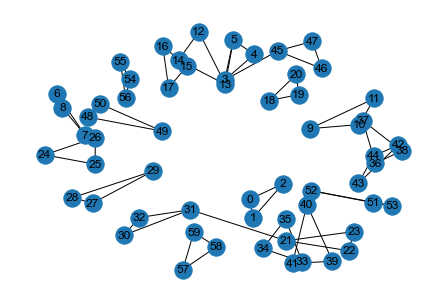

In [26]:
# clique model
graph_viz(adj_mat)

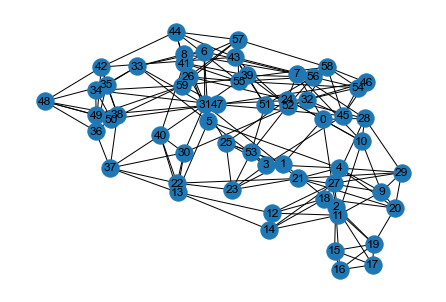

In [27]:
# clique model + augmented edges
graph_viz(adj_mat_aug)

# Experiment

In [34]:
def run_experiment(s = 2, N = 100, l = 2, k = 5 , p_in_unnorm = 0.01, p_out_unnorm = 0.005, p_par = 0.9):

    result_lpa = []
    result_alpa = []
    num_points = N*s
    for _ in range(30):
        final_adj_mat, final_adj_mat_ag, labels = gen_clique_model(s = s, N = N, k = k , p_in_unnorm = p_in_unnorm, p_out_unnorm = p_out_unnorm, p_par = p_par)

        # Label prop
        S_x = normalize_matrix(final_adj_mat > 0)
        S_x_ag = normalize_matrix(final_adj_mat_ag > 0)
        labeled_inds = np.concatenate((np.random.choice(range(num_points), size=l, replace=False), \
                        num_points+ (np.random.choice(range(num_points), size=l, replace=False))))

        f_lpa = PropagationHard(np.ones((2*num_points, 2))*0.5, S_x, labels, labeled_inds, alpha = 100)
        f_alpa = PropagationHard(np.ones((2*num_points, 2))*0.5, S_x_ag, labels, labeled_inds, alpha = 100)


        result_lpa.append([100*AdjustAcc(f_lpa, labels), 100*NotAbstainAcc(f_lpa, labels), s, N , l, k , p_in_unnorm, p_out_unnorm , p_par, 'LPA'])
        result_alpa.append([100*AdjustAcc(f_alpa, labels), 100*NotAbstainAcc(f_alpa, labels), s, N , l, k , p_in_unnorm, p_out_unnorm , p_par, 'ALPA'])
    return result_lpa + result_alpa

### P_partition vs Accuracy

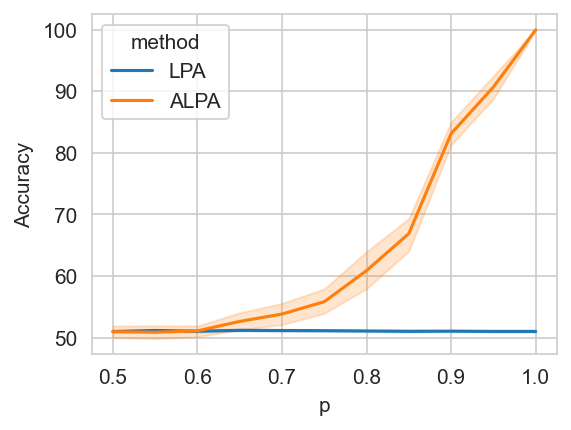

In [39]:
# regime : not connected
result = []
for p_par in np.linspace (0.5, 1.0,11):
    result += run_experiment(s = 3, N = 100, l = 2, k = 5 , p_in_unnorm = 0.01, p_out_unnorm = 0.005, p_par = p_par)
df = pd.DataFrame(result, columns = ['Accuracy', 'NotabsAcc','s','N','l','k','p_in','p_out','p','method'])
df_group = df.groupby(['method','p']).mean()
plt.figure(figsize= (4,3), dpi = 150)
sns.lineplot(data = df, x = 'p', y = 'Accuracy', hue = 'method')
plt.show()

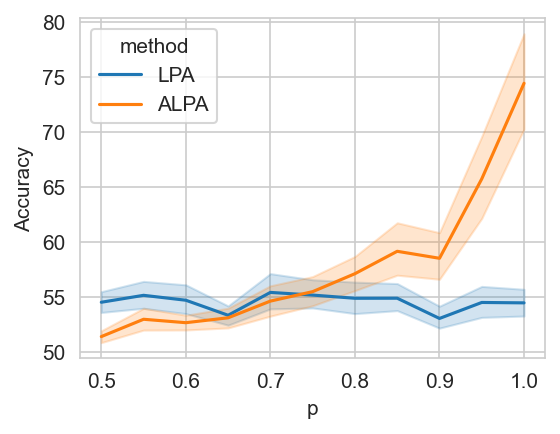

In [40]:
# regime: connected but noisy edges
result = []
for p_par in np.linspace (0.5, 1.0,11):
    result += run_experiment(s = 3, N = 100, l = 2, k = 5 , p_in_unnorm = 0.4, p_out_unnorm = 0.2, p_par = p_par)
df = pd.DataFrame(result, columns = ['Accuracy', 'NotabsAcc','s','N','l','k','p_in','p_out','p','method'])
df_group = df.groupby(['method','p']).mean()
plt.figure(figsize= (4,3), dpi = 150)
sns.lineplot(data = df, x = 'p', y = 'Accuracy', hue = 'method')
plt.show()

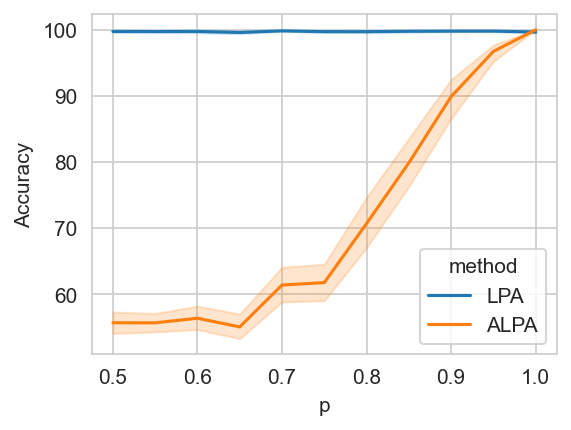

In [41]:
# regime: connected and clean edges
result = []
for p_par in np.linspace (0.5, 1.0,11):
    result += run_experiment(s = 3, N = 100, l = 2, k = 5 , p_in_unnorm = 0.4, p_out_unnorm = 0.005, p_par = p_par)
df = pd.DataFrame(result, columns = ['Accuracy', 'NotabsAcc','s','N','l','k','p_in','p_out','p','method'])
df_group = df.groupby(['method','p']).mean()
plt.figure(figsize= (4,3), dpi = 150)
sns.lineplot(data = df, x = 'p', y = 'Accuracy', hue = 'method')
plt.show()

### p_in vs acc

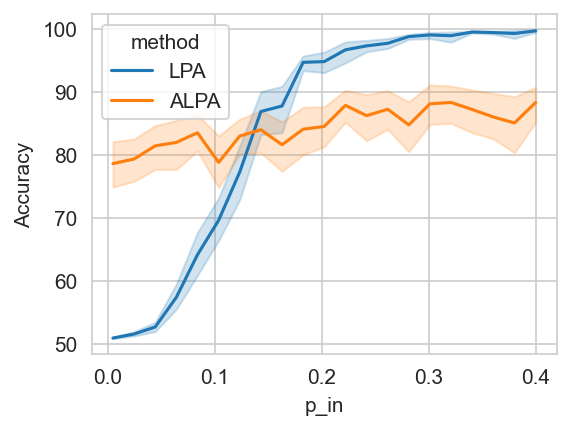

In [42]:
# regime: connected + clean edges
result = []
for p_in_unnorm in np.linspace (0.005, 0.4,21):
    result += run_experiment(s = 3, N = 100, l = 2, k = 5 , p_in_unnorm = p_in_unnorm, p_out_unnorm = 0.005, p_par = 0.9)
df = pd.DataFrame(result, columns = ['Accuracy', 'NotabsAcc','s','N','l','k','p_in','p_out','p_par','method'])
df_group = df.groupby(['method','p_in']).mean()
plt.figure(figsize= (4,3), dpi = 150)
sns.lineplot(data = df, x = 'p_in', y = 'Accuracy', hue = 'method')
plt.show()

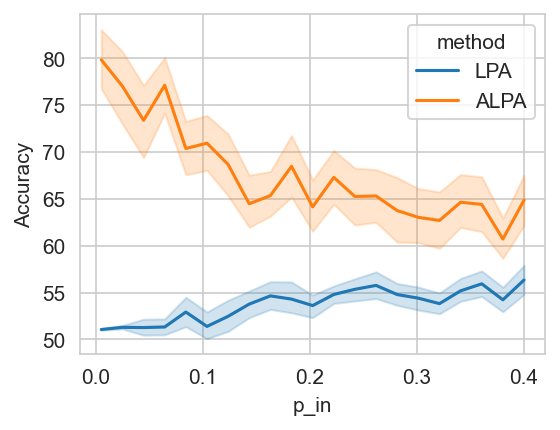

In [43]:
# regime: connected + noisy edges
result = []
for p_in_unnorm in np.linspace (0.005, 0.4,21):
    result += run_experiment(s = 3, N = 100, l = 2, k = 5 , p_in_unnorm = p_in_unnorm, p_out_unnorm = p_in_unnorm/2, p_par = 0.9)
df = pd.DataFrame(result, columns = ['Accuracy', 'NotabsAcc','s','N','l','k','p_in','p_out','p_par','method'])
df_group = df.groupby(['method','p_in']).mean()
plt.figure(figsize= (4,3), dpi = 150)
sns.lineplot(data = df, x = 'p_in', y = 'Accuracy', hue = 'method')
plt.show()